In [1]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

In [34]:
env = gym.make('Taxi-v3', render_mode='rgb_array').env
# env = gym.make('CartPole-v1', render_mode='rgb_array')
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)

In [35]:
class ReplayBuffer:
    def __init__(self):
        pass
    
    def __len__(self) -> int:
        return self.size

In [36]:
class QNetwork(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super(QNetwork, self).__init__()
        '''注意网络的定义为Q(s,a;w),隐变量为w,输入为状态s,输出为当前状态s下所有可能动作A的最大未来收益'''
        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''前向推理实现'''
        return self.layers(x)

In [37]:
obs_dim = env.observation_space.n
action_dim = env.action_space.n

# 构建两个Q函数，其中Q为，Q_target为
Q = QNetwork(obs_dim, action_dim).to(device)
Q_target = QNetwork(obs_dim, action_dim).to(device)
Q_target.load_state_dict(Q.state_dict())
Q_target.eval()

#
optimizer = optim.Adam(Q.parameters())

In [93]:
epsilon = 0.8
def select_action(state):
    # 选择动作，有0.2的概率进行随机探索
    if np.random.random() > epsilon:
        return env.action_space.sample(env.action_mask(state))
    
    # 有0.8的概率从当前训练的Q函数中，预测所有可能动作的Q值
    cur_state = taxi_state(state)
    q_value = Q(torch.FloatTensor(cur_state).to(device))
    fill_value = torch.zeros([1, action_dim])
    print(q_value, fill_value)
    indx_tensor = torch.BoolTensor(np.where(env.action_mask(state) == 1)).to(device)
    print(indx_tensor)
    t = torch.where(indx_tensor[0], q_value, fill_value)
    print('t', t)
    indexes = q_value[np.where(env.action_mask(state) == 1)[0]].to(device)
    print(indexes)
    action = indexes.argmax().detach().cpu().numpy()
    return action

# 
state, _ = env.reset()
for i in range(10):
    v = select_action(state)
    print(v)
def taxi_state(state):
    init_state = torch.tensor([state])
#     print(init_state)
    return F.one_hot(init_state, num_classes = obs_dim).numpy()[0].tolist()

# state, _ = env.reset()
# a = env.action_space.sample(env.action_mask(state))
# print(a)
# next_state, reward, done, _, _ = env.step(a)


tensor([-0.0309, -0.0850, -0.0721,  0.0440,  0.0350, -0.0506],
       grad_fn=<ViewBackward0>) tensor([[0., 0., 0., 0., 0., 0.]])
tensor([[False,  True,  True,  True]])


/opt/homebrew/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.action_mask to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_mask` for environment variables or `env.get_wrapper_attr('action_mask')` that will search the reminding wrappers.
  logger.warn(


RuntimeError: The size of tensor a (4) must match the size of tensor b (6) at non-singleton dimension 0

In [82]:
gamma = 0.85
seed = 3

scores = []
losses = []
#假设要跑100幂
epoch = 200
while True:
    if epoch <= 0:
        break
    
    epoch -= 1
    score = 0
    '''使用如下方式时，state的类型是list，否则是一个array'''
    state, _ = env.reset()
    
    while True:
        '''这里代理选择一个动作来执行'''
        action = select_action(state)
        '''得到下一个状态,构成(s,a,r,s')'''
        print(action)
#         ret = env.step(action)
#         print(ret)
        next_state, reward, done, truncated, _ = env.step(action)
        
        score += reward
        if done:
            scores.append(score)
            break
            
#         next_target = taxi_state(next_state)
#         cur_state = taxi_state(state)
#         '''
#         这里可以计算Q_*(s, A)，以及Q_*(s', A),然后用TD算法，逼近Q_*
#         '''
#         q_value = Q(torch.FloatTensor(cur_state).to(device))
        
#         next_q_value = Q(torch.FloatTensor(next_target).to(device))
#         target = reward + gamma * next_q_value
        
#         loss = F.smooth_l1_loss(q_value, target)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         losses.append(loss.item())
#         cur_state = next_target

0
3


TypeError: unhashable type: 'numpy.ndarray'

In [7]:
# 观察效果
def test():
    dvideo_env = gym.wrappers.RecordVideo(env, video_folder='.')
    state, _ = dvideo_env.reset(seed=seed)
    done = False
    score = 0

    while not done:
        action = select_action(state)
        next_state, reward, done, truncated, _ = dvideo_env.step(action)

        state = next_state
        score += reward

    print("score: ", score)
    dvideo_env.close()
    
test()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/webberg/workspace/code/reinforce_learning/rainbow folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/webberg/workspace/code/reinforce_learning/rainbow/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/webberg/workspace/code/reinforce_learning/rainbow/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/webberg/workspace/code/reinforce_learning/rainbow/rl-video-episode-0.mp4
score:  11.0


In [18]:
print(losses[0], len(losses))

1.502861550761736e-06 9859


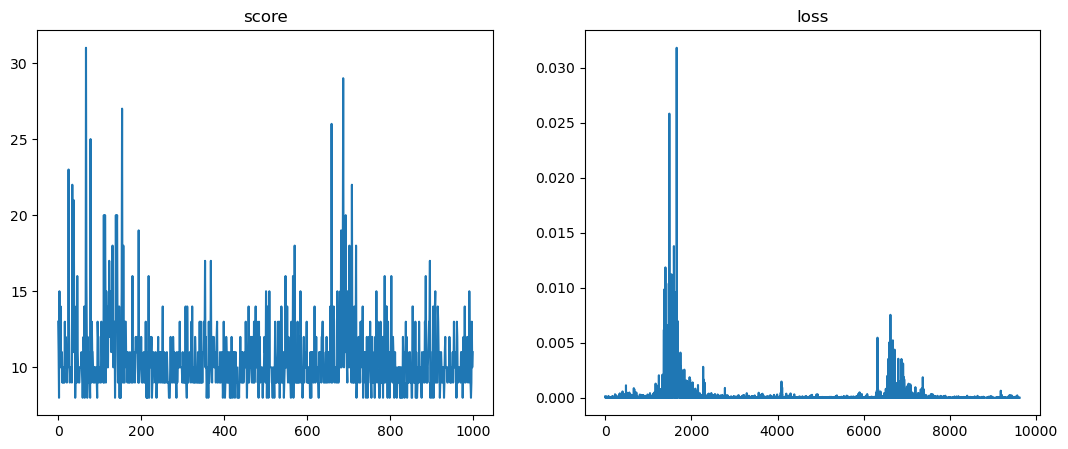

In [15]:
# 观察曲线
plt.figure(figsize=(20, 5))
plt.subplot(131)
# plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
plt.title('score')
plt.plot(scores)
plt.subplot(132)
plt.title('loss')
plt.plot(losses)
# plt.subplot(133)
# plt.title('epsilons')
# plt.plot(epsilons)
plt.show()